### Data Preparation and Class Weighting

This section performs preprocessing and dataset loading for the BloodMNIST classification task.


In [4]:
import torchvision.transforms as transforms
from medmnist import INFO
from medmnist.dataset import BloodMNIST
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch.nn as nn

# Get dataset info
info = INFO['bloodmnist']
DataClass = BloodMNIST

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])  # grayscale normalization
])

# Load datasets
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


targets = np.array([label for _, label in train_dataset])
if targets.ndim > 1:
    targets = np.argmax(targets, axis=1)

weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)



### Visual Inspection of BloodMNIST Samples

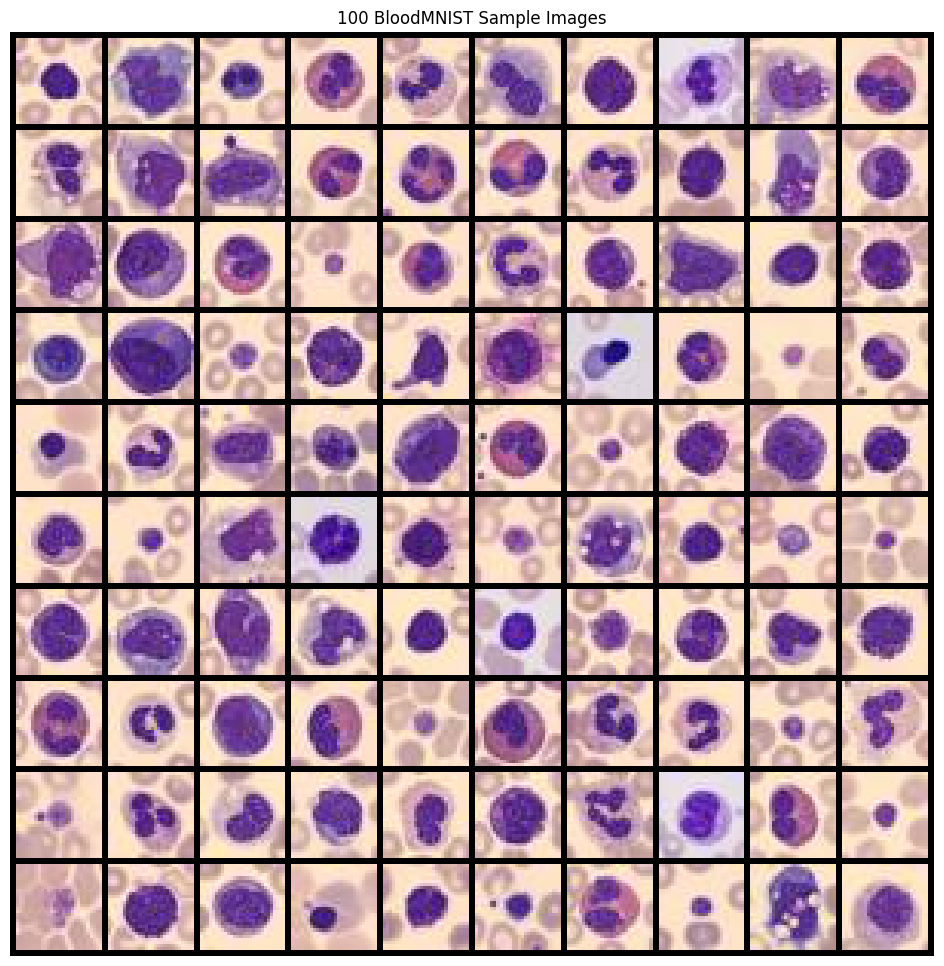

In [5]:
import matplotlib.pyplot as plt
import torchvision

# Get 100 images and labels
images, labels = next(iter(DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)))

# Create a grid of images
grid_img = torchvision.utils.make_grid(images, nrow=10, padding=2, normalize=True)

# Plot the image grid
plt.figure(figsize=(12, 12))
plt.imshow(grid_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.axis('off')
plt.title('100 BloodMNIST Sample Images')
plt.show()


### Dataset Structure Summary

In [6]:
# Extract details
sample_image, sample_label = train_dataset[0]
train_size = len(train_dataset)
test_size = len(test_dataset)
image_shape = sample_image.shape
label_names = info['label']

print("Image shape (C, H, W):", image_shape)
print("Sample label index:", sample_label)
print("Label names:", label_names)
print("Training set size:", train_size)
print("Test set size:", test_size)

Image shape (C, H, W): torch.Size([3, 28, 28])
Sample label index: [7]
Label names: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
Training set size: 11959
Test set size: 3421


### Class Distribution in Training Set

This section computes and displays the class prevalence in the BloodMNIST training dataset.

In [7]:
import pandas as pd
import numpy as np

# Extract all labels from the training dataset
all_labels = np.array([label for _, label in train_dataset])

# Flatten if one-hot encoded
if all_labels.ndim > 1 and all_labels.shape[1] > 1:
    all_labels = np.argmax(all_labels, axis=1)

# Count occurrences of each label
unique, counts = np.unique(all_labels, return_counts=True)

# Create prevalence table
label_names = info['label']
label_table = pd.DataFrame({
    'Label Index': unique,
    'Label Name': [label_names[str(i)] for i in unique],
    'Count': counts,
    'Percentage': (counts / counts.sum() * 100).round(2)
})

print(label_table)


   Label Index                                         Label Name  Count  \
0            0                                           basophil    852   
1            1                                         eosinophil   2181   
2            2                                       erythroblast   1085   
3            3  immature granulocytes(myelocytes, metamyelocyt...   2026   
4            4                                         lymphocyte    849   
5            5                                           monocyte    993   
6            6                                         neutrophil   2330   
7            7                                           platelet   1643   

   Percentage  
0        7.12  
1       18.24  
2        9.07  
3       16.94  
4        7.10  
5        8.30  
6       19.48  
7       13.74  


### Convolutional Neural Network

We implemented a custom convolutional neural network (CNN) in PyTorch for multi-class classification of blood cell images.


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a simplified and higher-performing CNN model
class BloodMNIST_CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=8):
        super(BloodMNIST_CNN, self).__init__()

        # First convolutional layer: 3 input channels → 32 output channels
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        # Second convolutional layer: 32 → 64 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Max pooling to reduce spatial dimensions by factor of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # After 2 poolings, 28x28 → 14x14 → 7x7 → 64 channels
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Apply convolution → ReLU → pooling
        x = self.pool(F.relu(self.conv1(x)))  # shape: (32, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))  # shape: (64, 7, 7)

        # Flatten the feature map into a vector
        x = x.view(x.size(0), -1)  # shape: (batch_size, 64*7*7)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Instantiate the model
cnn_model = BloodMNIST_CNN(in_channels=3, num_classes=8)

### Optimizer

We used the Adam optimizer from PyTorch to update the model parameters during training

In [10]:
import torch.optim as optim

optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

### Model Training

The model is trained for 10 epochs using the Adam optimizer and cross-entropy loss:


In [11]:
import torch
import torch.nn as nn

# Move model to CPU (or GPU if available and working)
device = torch.device("cpu")  # Force CPU to avoid libnccl errors
cnn_model.to(device)

# Define loss function: CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Train the model for 10 epochs
for epoch in range(10):
    cnn_model.train()  # Set model to training mode
    running_loss = 0.0

    # Iterate over all mini-batches in the training set
    for images, labels in train_loader:
        # Move inputs and labels to the same device as model
        images = images.to(device)
        labels = labels.squeeze().long().to(device)

        # Reset gradient accumulators
        optimizer.zero_grad()

        # Forward pass: compute model predictions
        outputs = cnn_model(images)

        # Compute loss between predictions and actual labels
        loss = criterion(outputs, labels)

        # Backward pass: compute gradient of loss w.r.t. model parameters
        loss.backward()

        # Update model weights using optimizer
        optimizer.step()

        # Accumulate total loss for this mini-batch
        running_loss += loss.item() * images.size(0)

    # Compute and print average loss for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/10 - Loss: {epoch_loss:.4f}")


Epoch 1/10 - Loss: 0.9775
Epoch 2/10 - Loss: 0.5097
Epoch 3/10 - Loss: 0.4171
Epoch 4/10 - Loss: 0.3580
Epoch 5/10 - Loss: 0.3074
Epoch 6/10 - Loss: 0.2829
Epoch 7/10 - Loss: 0.2627
Epoch 8/10 - Loss: 0.2419
Epoch 9/10 - Loss: 0.2252
Epoch 10/10 - Loss: 0.2016


### Model Evaluation

After training, we evaluate the model's performance on the test set:


In [12]:
import torch
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
from sklearn.metrics import classification_report

# Set model to evaluation mode
cnn_model.eval()

# Ensure model runs on CPU (or GPU if using it)
device = torch.device("cpu")
cnn_model.to(device)

# Prepare containers to store predictions and true labels
all_probs = []   # for predicted probabilities
all_preds = []   # for predicted class labels
all_targets = [] # for true labels

# Disable gradient computation for evaluation (faster, less memory)
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to same device as model
        images = images.to(device)
        labels = labels.squeeze().long().to(device)

        # Get raw model outputs (logits)
        outputs = cnn_model(images)

        # Apply softmax to convert logits to predicted class probabilities
        probs = torch.softmax(outputs, dim=1)

        # Get predicted class labels (index of max probability)
        preds = torch.argmax(probs, dim=1)

        # Store results for evaluation
        all_probs.append(probs.cpu().numpy())     # shape: (batch_size, num_classes)
        all_preds.append(preds.cpu().numpy())     # shape: (batch_size,)
        all_targets.append(labels.cpu().numpy())  # shape: (batch_size,)

# Concatenate results from all batches into full arrays
all_probs = np.concatenate(all_probs, axis=0)
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Compute overall classification accuracy
accuracy = accuracy_score(all_targets, all_preds)

# Convert labels to one-hot encoding for AUC computation
num_classes = all_probs.shape[1]
targets_onehot = np.eye(num_classes)[all_targets]

# Compute macro-average one-vs-rest AUC
auc = roc_auc_score(targets_onehot, all_probs, average='macro', multi_class='ovr')

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"One-vs-Rest AUC (macro-average): {auc:.4f}")


# Print accuracy and macro-average AUC again
print(f"Test Accuracy: {accuracy:.4f}")
print(f"One-vs-Rest AUC (macro-average): {auc:.4f}")

# Compute AUC for each class (one-vs-rest)
print("\nAUC for each class:")
for i in range(num_classes):
    class_auc = roc_auc_score(targets_onehot[:, i], all_probs[:, i])
    print(f"Class {i}: AUC = {class_auc:.4f}")

# Print precision, recall, F1-score for each class
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, digits=4))


Test Accuracy: 0.9076
One-vs-Rest AUC (macro-average): 0.9916
Test Accuracy: 0.9076
One-vs-Rest AUC (macro-average): 0.9916

AUC for each class:
Class 0: AUC = 0.9834
Class 1: AUC = 0.9993
Class 2: AUC = 0.9957
Class 3: AUC = 0.9741
Class 4: AUC = 0.9961
Class 5: AUC = 0.9869
Class 6: AUC = 0.9971
Class 7: AUC = 1.0000

Classification Report:
              precision    recall  f1-score   support

           0     0.8304    0.7828    0.8059       244
           1     0.9747    0.9872    0.9809       624
           2     0.9290    0.9260    0.9275       311
           3     0.8302    0.7686    0.7982       579
           4     0.8745    0.8889    0.8816       243
           5     0.7106    0.8732    0.7836       284
           6     0.9768    0.9474    0.9619       666
           7     0.9979    1.0000    0.9989       470

    accuracy                         0.9076      3421
   macro avg     0.8905    0.8968    0.8923      3421
weighted avg     0.9104    0.9076    0.9080      3421

